# PLUG FLOW REACTOR COM VARIAÇÃO DE AREA

In [3]:
"""
Cabeçalho
Apresentação legal, explicando o que ele faz
Requires: cantera >= 2.5.0, scipy >= 0.19, matplotlib >= 2.0
"""

%matplotlib inline
import cantera as ct
import numpy as np
import scipy.integrate
from scipy.interpolate import interp1d as i1d
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline as us1d
#Limites de x -0.00104,0.500

## Definição da Geometria:  A(x) e dAdx(x)

<DIV STYLE="background-color:#000000; height:3px; width:100%;">

In [2]:
import time
start = time.time()

XR = np.loadtxt('./Data/T2-Contorno.txt')

x    = XR[:,0]*1e-3
A    = us1d( x, 3.14159*XR[:,1]**2,k=3)
dAdx = A.derivative()

### Plot A(X) e dA(x)/dx

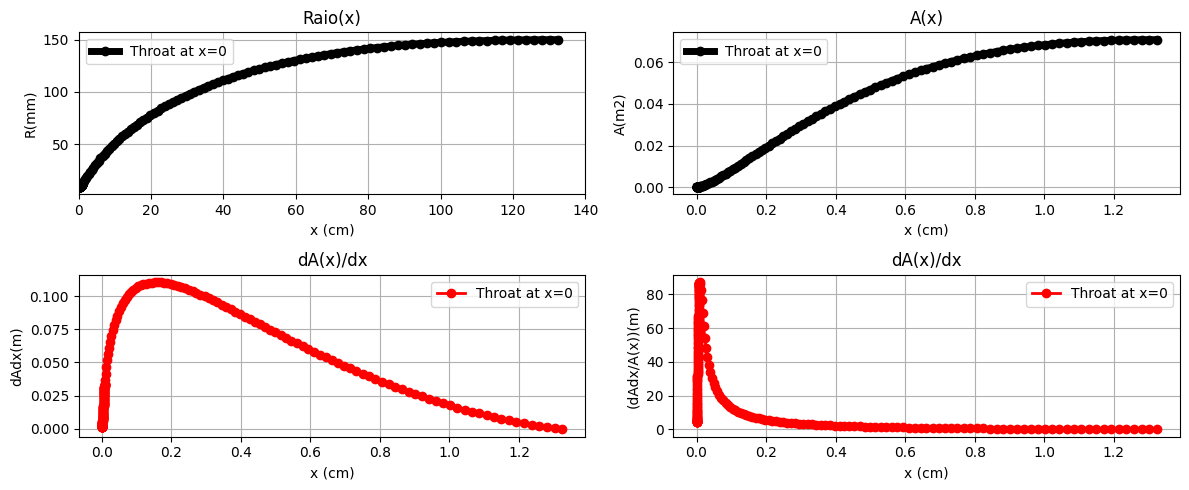

In [3]:

#plt.plot(XR[:,0], 3.1416*XR[:,1]**2.0,'ko-')
#plt.plot(XR[:,0],dAdx(XR[:,0]),'r-')

plt.figure(figsize=(12,5),dpi=100)

plt.subplot(2,2,1)
plt.plot( XR[:,0]/10, XR[:,1], '-ok', lw=5  )
plt.xlabel('x (cm)'),plt.ylabel('R(mm)'),plt.title('Raio(x)'),plt.grid()
plt.legend(['Throat at x=0'])
plt.xlim(0,140)

plt.subplot(2,2,2)
plt.plot( x, A(x)*1e-6, '-ok', lw=5  )
plt.xlabel('x (cm)'),plt.ylabel('A(m2)'),plt.title('A(x)'),plt.grid()
plt.legend(['Throat at x=0'])
#plt.ylim(-0.01,0.01)

plt.subplot(2,2,3)
plt.plot( x, dAdx(x)*1e-6, '-or', lw=2  )
plt.xlabel('x (cm)'),plt.ylabel('dAdx(m)'),plt.title('dA(x)/dx'),plt.grid()
plt.legend(['Throat at x=0'])

plt.subplot(2,2,4)
plt.plot( x, dAdx(x)/A(x) , '-or', lw=2  )
plt.xlabel('x (cm)'), plt.ylabel('(dAdx/A(x))(m)'), plt.title('dA(x)/dx'),plt.grid()
plt.legend(['Throat at x=0'])


plt.tight_layout()

## Equacionamento do PFR 

<DIV STYLE="background-color:#000000; height:3px; width:100%;">

In [4]:
class PFR_Ode:
    def __init__(self, gas, mdot):
        self.gas  = gas
        self.mdot = mdot


    def __call__(self, x, Y):  

        self.gas.TDY = Y[0], Y[1], Y[2::]

        rho = self.gas.density
        T   = self.gas.T
        y   = self.gas.Y
       
        MW_mix = self.gas.mean_molecular_weight
        Rnd    = ct.gas_constant/(self.gas.cp_mass*MW_mix) # non-dimensional R = 1 - cp/cv
        
        ux = self.mdot/(rho*(A(x)*1e-6))

        P = rho*(ct.gas_constant/MW_mix)*T

        MW = self.gas.molecular_weights
        h  = self.gas.standard_enthalpies_RT*(ct.gas_constant/MW_mix)*T
        w  = self.gas.net_production_rates
        cp = self.gas.cp_mass
            
        drhodx = (((rho*ux)**2.)*(1.-Rnd)*(dAdx(x)/A(x))+(rho/ux)*Rnd*np.sum(MW*w*(h-(MW_mix/MW)*cp*T)))/(P*(1.+ux**2./(cp*T)) - rho*ux**2.)
        dTdx   = (ux**2./cp)*(drhodx/rho +  dAdx(x)/A(x)) - np.sum(h*w*MW)/(ux*rho*cp)   
        dYdx   =  w*MW/(rho*ux)
                                   
        return np.hstack((dTdx, drhodx, dYdx))

### Especificando as Condições Iniciais e o Solver das EDOs:

In [17]:
#Condicoes Iniciais
gas  = ct.Solution('./Data/Redlich-Kwong_Air.yaml')
#gas  = ct.Solution('air.cti')

print('Estagnação')
T0 = 4100
P0 = 9e6
X0  = 'O2:0.21, N2:0.79' 

gas.TPX = T0, P0, X0
gas.equilibrate('TP')
g0 = gas.cp/gas.cv
print(gas())
print('gamma:', round(gas.cp/gas.cv,5))
print('Z:', round( gas.P/(gas.density*(ct.gas_constant/gas.mean_molecular_weight)*gas.T ) ,5))
print('cv:', round( gas.cv_mass,3))
print('cp:', round( gas.cp_mass,3))
print('mm:', round( gas.mean_molecular_weight,3))




#-------------------------------------
print('Garganta')
Tth = ((1+0.5*(g0-1))**-1)*T0
Pth = ((1+0.5*(g0-1))**(-g0/(g0-1)))*P0
XX  = 'o2:0.21, n2:0.79' 
#-------------------------------------
gas.TPX = Tth, Pth, XX
gas.equilibrate('TP')
print(gas())
print('gamma:', round(gas.cp/gas.cv,5))
print('Z:', round( gas.P/(gas.density*(ct.gas_constant/gas.mean_molecular_weight)*gas.T ) ,5))



mdot = 1.01*gas.density*np.sqrt( (gas.cp/gas.cv)*(8314/gas.mean_molecular_weight)*gas.T )*(3.14159*(XR[0,1]*1e-3)**2 )

u0 = mdot/(gas.density*(A(0)*1e-6))
g0 = gas.cp/gas.cv
M0 = u0/( np.sqrt(g0*(ct.gas_constant/gas.mean_molecular_weight)*gas.T)  )
h0 = gas.enthalpy_mass
zz = gas.P/(gas.density*(ct.gas_constant/gas.mean_molecular_weight)*gas.T)


states = ct.SolutionArray(gas, 1, extra={ 'x':[0], 'tempo':[0], 'dt':[0], 'Mach':[M0], 'Velocity':[u0], 'Enthalpy':[h0], 'Gamma':[g0], 'Z_Fator':[zz] })
Y0 = np.hstack((gas.T, gas.density,  gas.Y))
x0 = 0

#Solver
ode    = PFR_Ode(gas, mdot)        #objeto
solver = scipy.integrate.ode(ode)  #objeto

solver.set_integrator(name='vode', method='bdf', with_jacobian=True)
solver.set_initial_value(Y0,x0)
print()
print('Mach na Garganta:', round(M0,5))
print('mdot:', round(mdot,5))
print('gamma:', round(gas.cp/gas.cv,5))

Estagnação

  real_air:

       temperature   4100 K
          pressure   9e+06 Pa
           density   7.3182 kg/m^3
  mean mol. weight   27.894 kg/kmol
   phase of matter   unspecified

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        5.6275e+06        1.5697e+08  J
   internal energy        4.3977e+06        1.2267e+08  J
           entropy            8920.7        2.4883e+05  J/K
    Gibbs function       -3.0947e+07       -8.6324e+08  J
 heat capacity c_p            1328.6             37059  J/K
 heat capacity c_v            1030.3             28740  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                 O          0.038083          0.066397           -14.573
                O2            0.1411             0.123           -29.146
                 N         0.0001149        0.00022881 

### Integrando as EDOs:

In [18]:
dx, x_end = 1e-3, XR[-1,0]*1e-3 #Passo e comprimento total da tubeira

tempo = 0
for x in np.arange(x0+dx,x_end+dx,dx): 

    try:
        solver.integrate(x)  
    except:     
        print('Erro em x = ', x)
            
    gas.TDY = solver.y[0], solver.y[1], solver.y[2::]
    
    #outros parametros
    hx      = gas.enthalpy_mass    
    ux      = mdot/((A(x)*1e-6)*gas.density) 
    MW_mix  = gas.mean_molecular_weight
    gamma   = gas.cp/gas.cv
    a_sound = np.sqrt( gamma*(ct.gas_constant/MW_mix)*gas.T )     
    Mach    = ux/a_sound
    tempo   = tempo + dx/ux
    zz      = gas.P/(gas.density*(ct.gas_constant/gas.mean_molecular_weight)*gas.T)

    states.append(gas.state,  x=solver.t, tempo=tempo, dt=dx/ux, Mach=Mach, Velocity=ux, Enthalpy=hx, Gamma=gamma, Z_Fator=zz)
    
end  = time.time()
print('Tempo:', round(end - start,3), ' s' ) 

Tempo: 707.874  s


## Solução

<DIV STYLE="background-color:#000000; height:3px; width:100%;">

#### Escoamento Livre

In [19]:
print('Pressão psi:'    , np.round(14.7*states.P[-1]/ct.one_atm,2) )
print('Pressão pa:'     , np.round(states.P[-1],2)                 )
print('Temperatura K:'  , np.round(states.T[-1],2)                 )
print('Velocidade m/s:' , np.round(states.Velocity[-1],2)          )

Pressão psi: 0.13
Pressão pa: 870.36
Temperatura K: 456.35
Velocidade m/s: 3064.5


### Temperatura, Pressão e Densidade

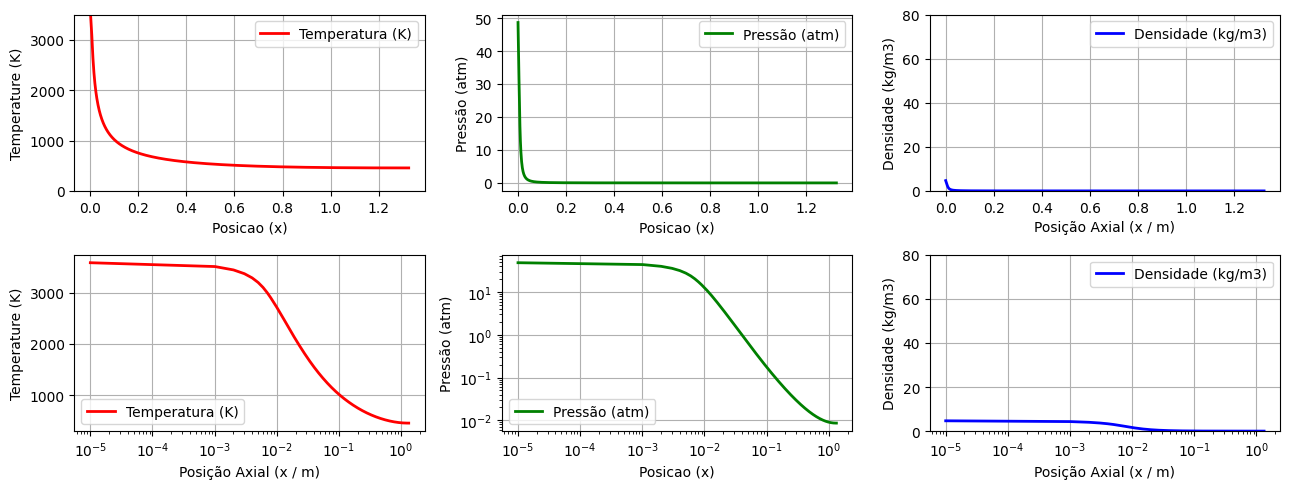

In [20]:
plt.figure(figsize=(13,5))

plt.subplot(2,3,1)
plt.plot(states.x+1e-5, states.T, color='r', label='Temperatura (K)', lw=2)
plt.xlabel('Posicao (x)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.ylim(0,3500)
plt.grid()

plt.subplot(2,3,2)
plt.plot(states.x+1e-5, states.P/101325, color='green', label='Pressão (atm)', lw=2)
plt.xlabel('Posicao (x)')
plt.ylabel('Pressão (atm)')
plt.legend()
plt.grid()

plt.subplot(2,3,3)
plt.plot(states.x+1e-5, states.density, color='blue', label='Densidade (kg/m3)', lw=2)
plt.xlabel('Posição Axial (x / m)')
plt.ylabel('Densidade (kg/m3)')
plt.legend()
plt.ylim(0,80)
plt.grid()


plt.subplot(2,3,4)
plt.semilogx(states.x+1e-5, states.T, color='r', label='Temperatura (K)', lw=2)
plt.xlabel('Posição Axial (x / m)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.grid()

plt.subplot(2,3,5)
plt.loglog(states.x+1e-5, states.P/101325, color='green', label='Pressão (atm)', lw=2)
plt.xlabel('Posicao (x)')
plt.ylabel('Pressão (atm)')
plt.legend()
plt.grid()

plt.subplot(2,3,6)
plt.semilogx(states.x+1e-5, states.density, color='blue', label='Densidade (kg/m3)', lw=2)
plt.xlabel('Posição Axial (x / m)')
plt.ylabel('Densidade (kg/m3)')
plt.legend()
plt.ylim(0,80)
plt.grid()

plt.tight_layout()

### Velocidade e Mach

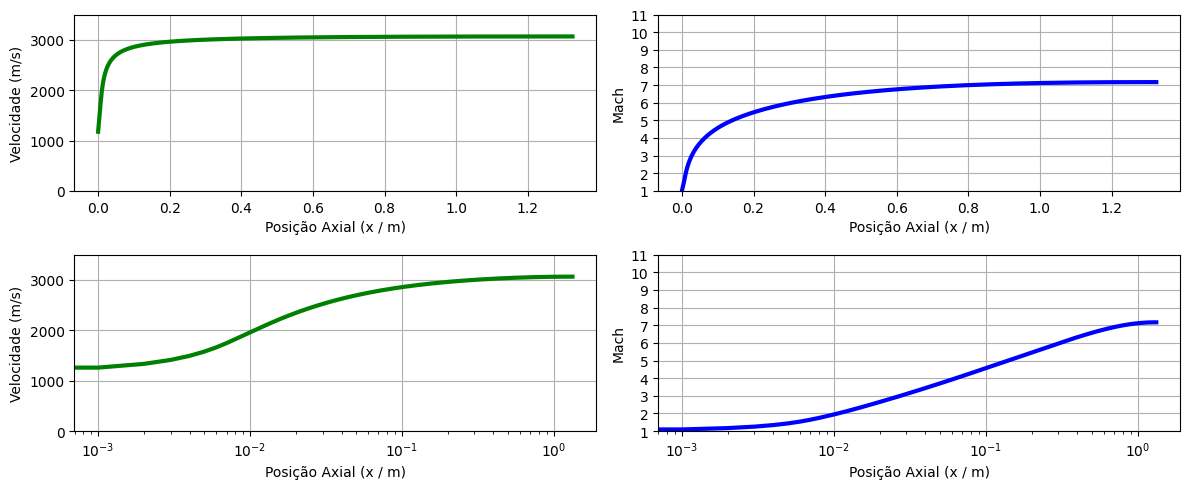

In [21]:
plt.figure(figsize=(12,5))

plt.subplot(2,2,1)
plt.plot(states.x, states.Velocity, lw=3,color='green')
plt.xlabel('Posição Axial (x / m)'),plt.ylabel('Velocidade (m/s)'),plt.grid()
plt.ylim(0,3500)

plt.subplot(2,2,2)
plt.plot(states.x, states.Mach, lw=3,color='blue')
plt.xlabel('Posição Axial (x / m)'),plt.ylabel('Mach'),plt.grid()
plt.ylim(1,11)
plt.yticks(np.arange(1,11.1,1))

plt.subplot(2,2,3)
plt.semilogx(states.x, states.Velocity, lw=3,color='green')
plt.xlabel('Posição Axial (x / m)'),plt.ylabel('Velocidade (m/s)'),plt.grid()
plt.ylim(0,3500)

plt.subplot(2,2,4)
plt.semilogx(states.x, states.Mach, lw=3,color='blue')
plt.xlabel('Posição Axial (x / m)'),plt.ylabel('Mach'),plt.grid()
plt.ylim(1,11)
plt.yticks(np.arange(1,11.1,1))

plt.tight_layout()

### Concentração de Espécies

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_11701/2957298549.py:28: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,0.05)


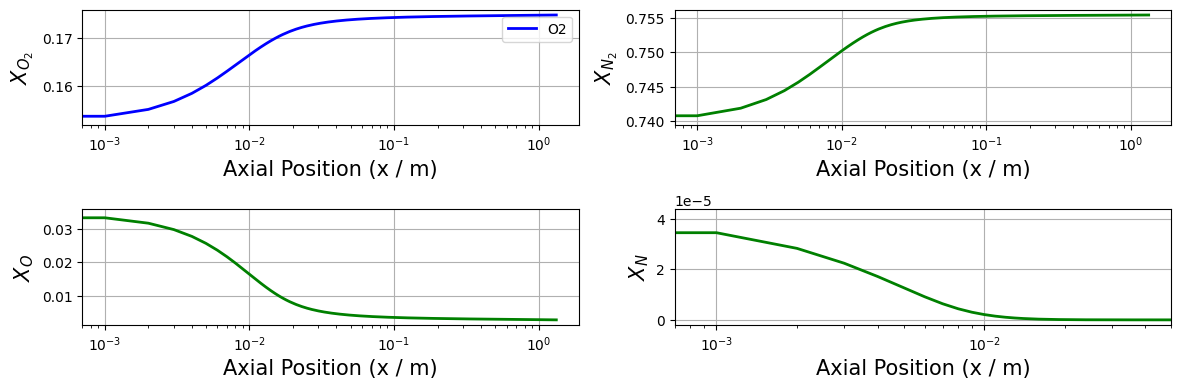

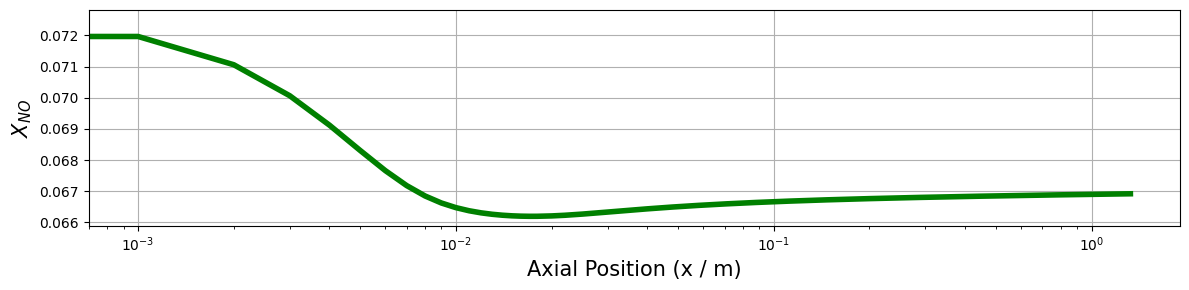

In [11]:
# Plot the results
plt.figure(figsize=(12,4))

plt.subplot(2,2,1)
plt.semilogx(states.x, states('O2').X, label='O2', lw=2,color='blue')
plt.xlabel('Axial Position (x / m)',fontsize=15)
plt.ylabel('$X_{O_2}$',fontsize=15)
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.semilogx(states.x, states('N2').X, label='N2', lw=2,color='green')
plt.xlabel('Axial Position (x / m)',fontsize=15)
plt.ylabel('$X_{N_2}$',fontsize=15)
plt.grid()

plt.subplot(2,2,3)
plt.semilogx(states.x, states('O').X, label='O', lw=2,color='green')
plt.xlabel('Axial Position (x / m)',fontsize=15)
plt.ylabel('$X_{O}$',fontsize=15)
plt.grid()

plt.subplot(2,2,4)
plt.semilogx(states.x, states('N').X, label='N', lw=2,color='green')
plt.xlabel('Axial Position (x / m)',fontsize=15)
plt.ylabel('$X_{N}$',fontsize=15)
plt.grid()
plt.xlim(0,0.05)

plt.tight_layout()

plt.figure(figsize=(12,3))
plt.semilogx(states.x, states('NO').X, label='NO', lw=4,color='green')
plt.xlabel('Axial Position (x / m)',fontsize=15)
plt.ylabel('$X_{NO}$',fontsize=15)
plt.grid()
plt.tight_layout()


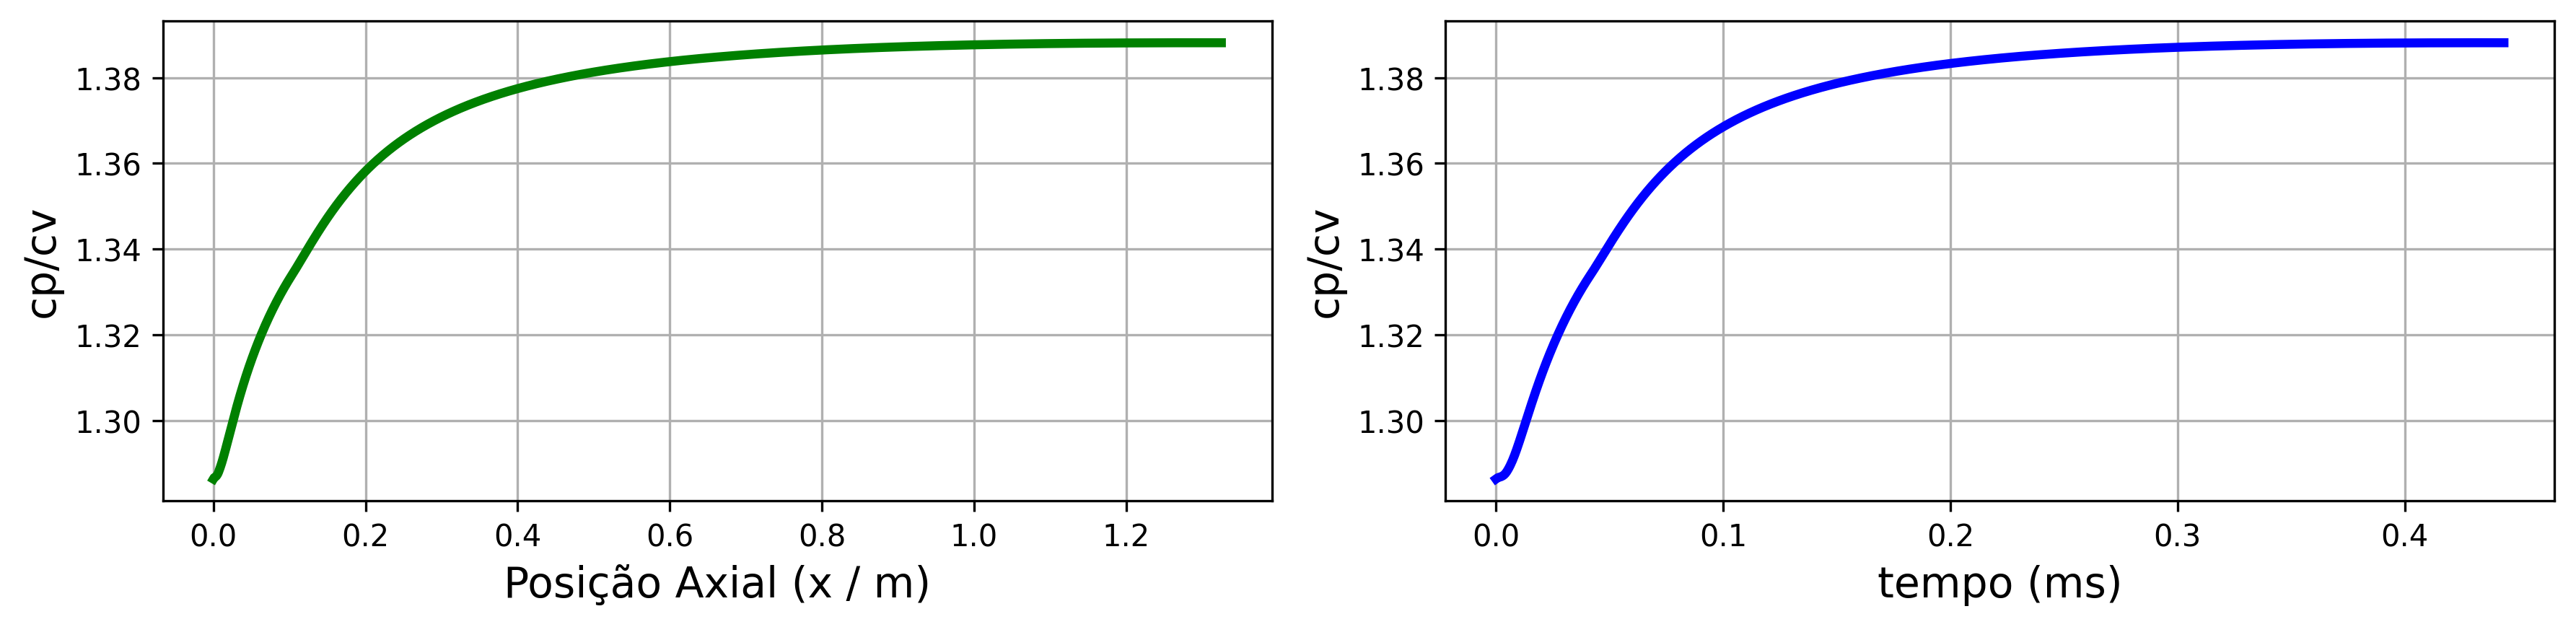

In [12]:
plt.figure(figsize=(12,3),dpi=300)

plt.subplot(1,2,1)
plt.plot(states.x, states.cp/states.cv, lw=3,color='green')
plt.xlabel('Posição Axial (x / m)',fontsize=14),plt.ylabel('cp/cv',fontsize=14),plt.grid()

plt.subplot(1,2,2)
plt.plot( 1e3*(states.tempo), states.cp/states.cv, lw=3,color='blue')
plt.xlabel('tempo (ms)',fontsize=14),plt.ylabel('cp/cv',fontsize=14),plt.grid()

plt.tight_layout()
#plt.savefig('Gama_Gas_Ideal.pdf')

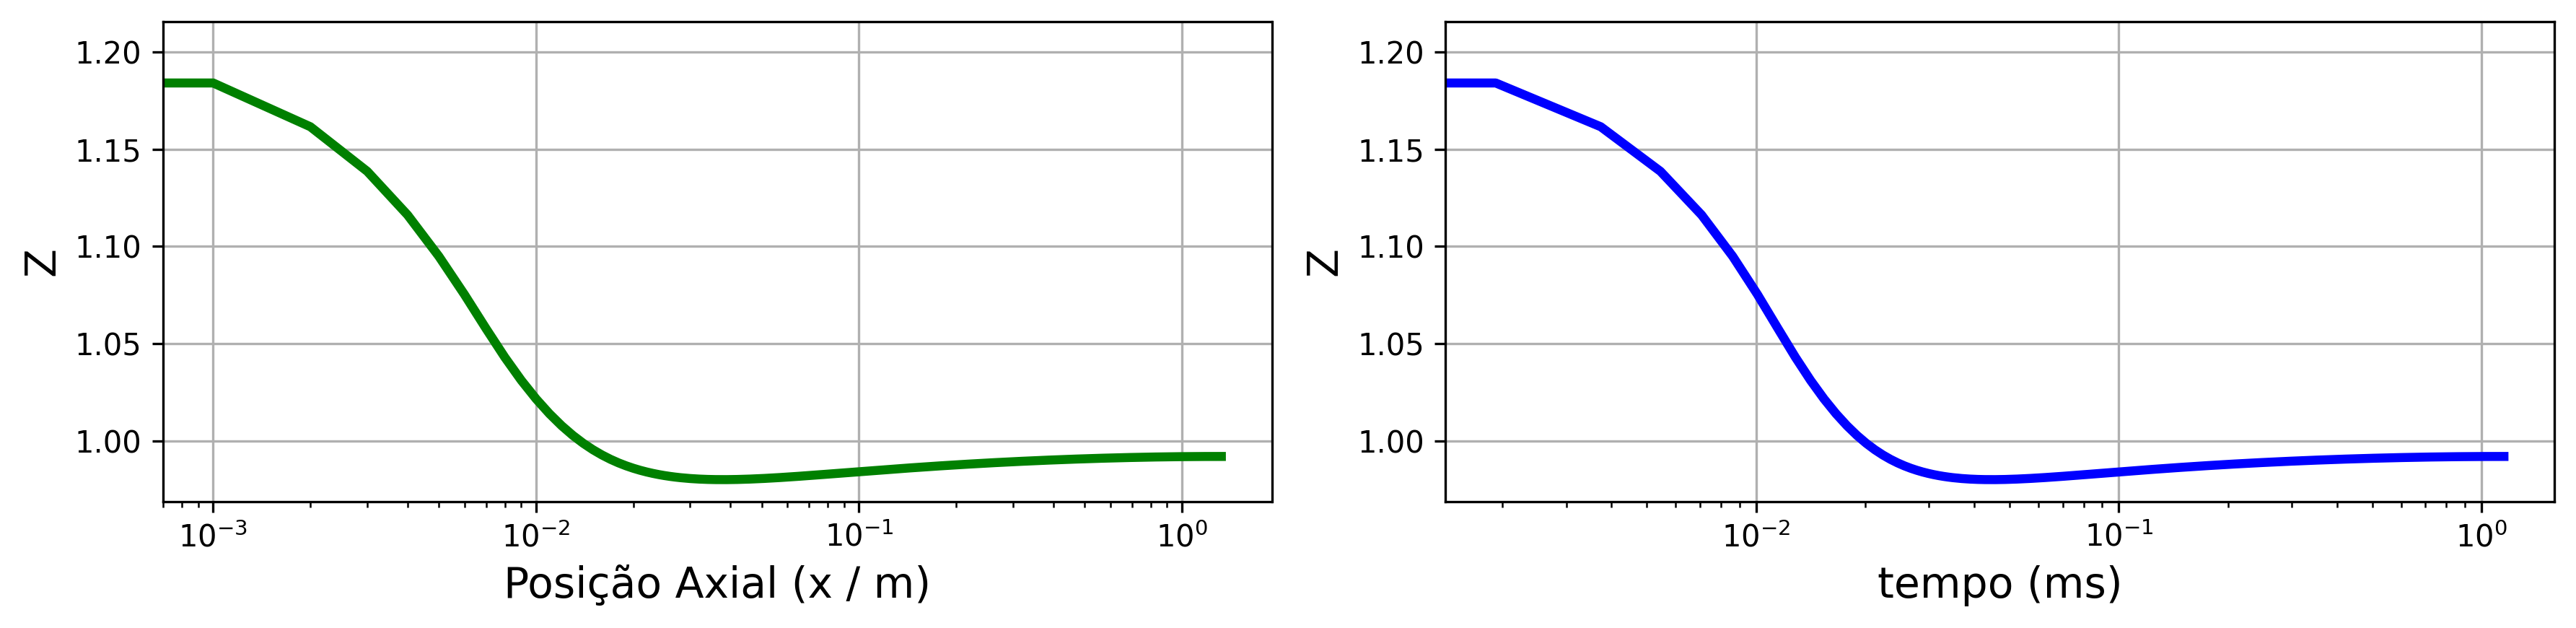

In [32]:
plt.figure(figsize=(12,3),dpi=300)

plt.subplot(1,2,1)
plt.semilogx(states.x, states.Z_Fator, lw=3,color='green')
plt.xlabel('Posição Axial (x / m)',fontsize=14),plt.ylabel('Z',fontsize=14),plt.grid()

plt.subplot(1,2,2)
plt.semilogx( 1e3*(states.tempo), states.Z_Fator, lw=3,color='blue')
plt.xlabel('tempo (ms)',fontsize=14),plt.ylabel('Z',fontsize=14),plt.grid()

plt.tight_layout()
#plt.savefig('Z_Gas_Ideal.pdf')

<DIV STYLE="background-color:#000000; height:10px; width:100%;">

In [33]:
xvalor = 6.032e-3 #215.274e-3
j1 = np.argmax( -np.abs(states.x-xvalor) )
print(xvalor,(states.cp/states.cv)[j1])

xvalor = 215.274e-3#1320e-3 #215.274e-3
j2 = np.argmax( -np.abs(states.x-xvalor) )
print(xvalor,(states.cp/states.cv)[j2])

0.006032 1.4581017851211766
0.215274 1.4372831437561258


#### Média Comum

In [34]:
print('0-1',(states.cp/states.cv)[0:j1].mean())
print('1-2',(states.cp/states.cv)[j1:j2].mean())
print('2-3',(states.cp/states.cv)[j2::].mean())

0-1 1.4487484206181571
1-2 1.440806837933049
2-3 1.4373503813611344


#### Média de $\gamma$ ponderada por $\frac{\Delta A(x)}{\Delta x}$: 
$<\gamma> = \frac{\sum_i \gamma(x_i)\frac{\Delta A(x_i)}{\Delta x_i}}{\sum\frac{\Delta A(x_i)}{\Delta x_i}}$

In [35]:
print('0-1')
dAdx_m = dAdx(states.x[0:j1]).sum()
print(((states.cp/states.cv)[0:j1]*dAdx(states.x[0:j1])).sum()/dAdx_m)
print('1-2')
dAdx_m = dAdx(states.x[j1:j2]).sum()
print(((states.cp/states.cv)[j1:j2]*dAdx(states.x[j1:j2])).sum()/dAdx_m)
print('2-3')
dAdx_m = dAdx(states.x[j2::]).sum()
print(((states.cp/states.cv)[j2::]*dAdx(states.x[j2::])).sum()/dAdx_m)

0-1
1.4520769736811652
1-2
1.4396969599449831
2-3
1.4372965219447469


#### Média de $\gamma$ ponderada por $\frac{1}{A(x)}\frac{dA(x)}{dx}$: 
$<\gamma> = \frac{\sum_i \gamma(x_i)\frac{1}{A(x_i)}\frac{\Delta A(x_i)}{\Delta x_i}}{\sum_i\frac{1}{A(x_i)}\frac{\Delta A(x_i)}{\Delta x_i}}$ 

In [16]:
print('0-1')
dAdx_m = (dAdx(states.x[0:j1])/A(states.x[0:j1])).sum()
print(((states.cp/states.cv)[0:j1]*(dAdx(states.x[0:j1])/A(states.x[0:j1]))).sum()/dAdx_m)
print('1-2')
dAdx_m = (dAdx(states.x[j1:j2])/A(states.x[j1:j2])).sum()
print(((states.cp/states.cv)[j1:j2]*(dAdx(states.x[j1:j2])/A(states.x[j1:j2]))).sum()/dAdx_m)
print('2-3')
dAdx_m = (dAdx(states.x[j2::])/A(states.x[j2::])).sum()
print(((states.cp/states.cv)[j2::]*(dAdx(states.x[j2::])/A(states.x[j2::]))).sum()/dAdx_m)




0-1
1.287033910202595
1-2
1.3258548716058998
2-3
1.3882087456781191


In [90]:
th = 3390
T = 5000
R = 8325
Mm = 28
cv = R/Mm*( (5/2) + ((th/T)**2)*np.exp(th/T)/(np.exp(th/T)-1)**2 )
print(cv)

1029.4925868831706


In [109]:
s = (2**(1/6))*3.12e-10
v = (4/3)*3.1415*s**3
A = 6.022e23
N = 0.028*(1/v)/A
N

258.4417657572968

In [101]:
s = 3.12e-10
r = 10*s
( (s/r)**12 - (s/r)**6 )

-9.999990000000004e-07

In [97]:
3.5**0.33333

1.5182881457407118

In [31]:
import cantera as ct
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d as i1d
from scipy.interpolate import UnivariateSpline as us1d


class PFR_Ode:
    def __init__(self, gas, mdot, A_x, dAdx_x):
        self.gas  = gas
        self.mdot = mdot
        self.A_x = A_x
        self.dAdx_x = dAdx_x

    def __call__(self, x, Y):  

        self.gas.TDY = Y[0], Y[1], Y[2::]

        rho = self.gas.density
        T   = self.gas.T
        y   = self.gas.Y
        A    = self.A_x
        dAdx = self.dAdx_x
       
        MW_mix = self.gas.mean_molecular_weight
        Rnd    = ct.gas_constant/(self.gas.cp_mass*MW_mix) # non-dimensional R = 1 - cp/cv
        
        ux = self.mdot/(rho*(A(x)))

        P = rho*(ct.gas_constant/MW_mix)*T

        MW = self.gas.molecular_weights
        h  = self.gas.standard_enthalpies_RT*(ct.gas_constant/MW_mix)*T
        w  = self.gas.net_production_rates
        cp = self.gas.cp_mass
            
        drhodx = (((rho*ux)**2.)*(1.-Rnd)*(dAdx(x)/A(x))+(rho/ux)*Rnd*np.sum(MW*w*(h-(MW_mix/MW)*cp*T)))/(P*(1.+ux**2./(cp*T)) - rho*ux**2.)
        dTdx   = (ux**2./cp)*(drhodx/rho +  dAdx(x)/A(x)) - np.sum(h*w*MW)/(ux*rho*cp)   
        dYdx   =  w*MW/(rho*ux)
                                   
        return np.hstack((dTdx, drhodx, dYdx))


class PFR_Solver:
    def __init__(self, **kargs):
        self.Tubeira(**kargs)
        self.Garganta(**kargs)

    
    def Tubeira(self, **kargs):
        x_0 = 0
        x_f = (kargs['r_f'] - kargs['r_0'])/np.tan(np.pi*kargs['ang']/180.)

        self.x = np.linspace(x_0, x_f, 5)*1e-3
        self.r = np.linspace(kargs['r_0'], kargs['r_f'], 5)*1e-3

        self.A = us1d( self.x, np.pi*self.r**2.0, k=3 )
        self.dAdx = self.A.derivative()    

    def Garganta(self,**kargs):
        self.gas = kargs['gas']
        self.T5  = kargs['T5']
        self.p5  = kargs['p5']
        self.X   = kargs['X']

        self.gas.TPX = self.T5, self.p5, self.X
        self.gas.equilibrate('TP')
        
        s5 = self.gas.entropy_mass
        g5 = self.gas.cp/self.gas.cv
        pg = self.p5*((1+0.5*(g5-1))**(-g5/(g5-1)))

        self.gas.SP = s5, pg
        self.gas.equilibrate('SP')
        gas_0 = self.gas

        r0 = gas_0.density
        g0 = gas_0.cp/gas_0.cv
        T0 = gas_0.T
        h0 = gas_0.enthalpy_mass

        self.mdot = 1.01*r0*np.sqrt( g0*(ct.gas_constant/gas_0.mean_molecular_weight)*T0 )*self.A(0)
        u0 = self.mdot/(r0*self.A(0))
        M0 = u0/( np.sqrt(g0*(ct.gas_constant/gas_0.mean_molecular_weight)*T0)  )

        self.states = ct.SolutionArray(self.gas, 1, extra={ 'x':[0], 'tempo':[0], 'dt':[0], 'Mach':[M0], 'Velocity':[u0], 'Enthalpy':[h0], 'Gamma':[g0]   })
        Y0 = np.hstack((self.gas.T, self.gas.density,  self.gas.Y))
    
    
        #Solver
        ode    = PFR_Ode(self.gas, self.mdot,self.A,self.dAdx)        #objeto
        solver = scipy.integrate.ode(ode)  #objeto

        solver.set_integrator(name='vode', method='bdf', with_jacobian=True)
        solver.set_initial_value(Y0,0)

        dx, x_end = 1e-3, self.x[-1] #Passo e comprimento total da tubeira

        tempo = 0
        for x in np.arange(dx,x_end+dx,dx): 

            try:
                solver.integrate(x)  
            except:     
                print('Erro em x = ', x)
                    
            gas.TDY = solver.y[0], solver.y[1], solver.y[2::]
            
            #outros parametros
            hx      = gas.enthalpy_mass    
            ux      = self.mdot/(self.A(x)*gas.density) 
            MW_mix  = gas.mean_molecular_weight
            gamma   = gas.cp/self.gas.cv
            a_sound = np.sqrt( gamma*(ct.gas_constant/MW_mix)*gas.T )     
            Mach    = ux/a_sound
            tempo   = tempo + dx/ux
            

            self.states.append(gas.state,  x=solver.t, tempo=tempo, dt=dx/ux, Mach=Mach, Velocity=ux, Enthalpy=hx, Gamma=gamma)
            
                


In [4]:
import Reactor
import cantera as ct
import matplotlib.pyplot as plt


gas  = ct.Solution('./Data/Redlich-Kwong_Air.yaml')

a = Reactor.PFR_Solver(r_0 = 6.4, r_f = 150.0, ang = 15.0, gas=gas, T5=4100, p5=8.7e6,X='O2:0.21, N2:0.79'  )
a.mdot

plt.figure(figsize=(8,3))

plt.plot(a.states.x, a.states['O2'].X, lw=3,color='green')
plt.xlabel('Posição Axial (x / m)'),plt.ylabel('Velocidade (m/s)'),plt.grid()
plt.ylim(0,3500)

AttributeError: 'SolutionArray' object has no attribute 'gas'

<Figure size 800x300 with 0 Axes>

In [25]:
x = np.linspace(0,0.5,10)
plt.plot(x,a.r(x))

TypeError: 'numpy.ndarray' object is not callable

In [1]:
import STube
gas8 = STube.STube_Calc(298, 11e3, 2100, 9e6, 'N2: 0.79 O2:0.21')
gas8.X

array([6.68926234e-02, 1.22635209e-01, 2.32656034e-04, 9.32919709e-02,
       2.27679137e-04, 5.20676442e-05, 7.16667794e-01])

In [4]:
gas  = ct.Solution('./Data/Redlich-Kwong_Air.yaml')

In [14]:
k = np.argsort(gas.X)
Xi = np.array(gas.species_names)
gas.X[k:0:-1]

TypeError: only integer scalar arrays can be converted to a scalar index